# **Proyek: Klasifikasi Gambar Tangan Kertas Gunting Batu**
Membuat sebuah model untuk mengklasifikasi gambar dan mampu mengenali bentuk tangan yang membentuk gunting, batu, atau kertas.

Nama: Natalia Syafitri Kustanto


## **Import Library**

In [ ]:
import zipfile 
import os

import numpy as np
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## **Data Preparation**


Dataset yang dipakai berisi total 2188 gambar tangan yang membentuk, 

*   'Rock'/Batu (726 images)
*   'Paper'/Kertas (710 images)
*   'Scissors'/Gunting (752 images) 

Seluruh gambar adalah RGB, berukuran 200x300 pixels, dengan format .png. Gambar dipisah tiga sub-folders bernama 'rock', 'paper' dan 'scissors'.


### **Mengunduh dataset**

In [ ]:
# Mengunduh dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-27 02:25:41--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  4.37MB/s    in 54s     

2021-07-27 02:26:35 (5.72 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]




### **Mengekstraksi dataset**
Mengekstrak dataset yang sebelumnya diunduh. Lalu mendefinisikan nama direktori untuk data latih dan data validasi.

In [ ]:
# melakukan ekstraksi pada file zip
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# cek isi dari direktori
os.listdir('/tmp/rockpaperscissors')

['rps-cv-images', 'scissors', 'README_rpc-cv-images.txt', 'paper', 'rock']

In [ ]:
os.listdir('/tmp/rockpaperscissors/rps-cv-images')

['scissors', 'README_rpc-cv-images.txt', 'paper', 'rock']

Menetapkan direktori diatas sebagai base directory

In [ ]:
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

## **Dataset Preprocessing**

### **Augmentasi Dataset**

Proses augmentasi gambar pada setiap sampel di dataset dan membagi gambar untuk train dan validasi

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=(1/255.),              # normalisasi vektor image, dividing with 255.
    width_shift_range=0.2,         # merandom shifting width dengan jarak 0.2
    height_shift_range=0.2,        # merandom shifting height dengan jarak 0.2
    zoom_range=0.2,                # merandom zoom dengan jarak 0.2
    shear_range=0.2,               # merandom shear dengan jarak 0.2
    rotation_range=20,             # merandom rotation dengan jarak 20 degree
    brightness_range=[0.8,1.2],    # merandom brightness diantara 0.8 - 1.2
    horizontal_flip=True,          # randomly flipping the image
    validation_split = 0.4,        # membagi data training 1314 sampel, dan data validasi 874 sampel
    fill_mode='nearest'            # use fill mode if dataset background are plain color
)

Menggunakan objek image data generator sebelumnya untuk mempersiapkan data latih yang akan dipelajari oleh model.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (100, 150),     # rescale image menjadi ukuran 100x150 pixels
    class_mode = 'categorical',   # tipe label (>2)
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (100, 150),
    class_mode = 'categorical',
    subset = 'validation'
)

print(train_generator.class_indices)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}


### **Plotting Dataset Hasil Augmentasi**

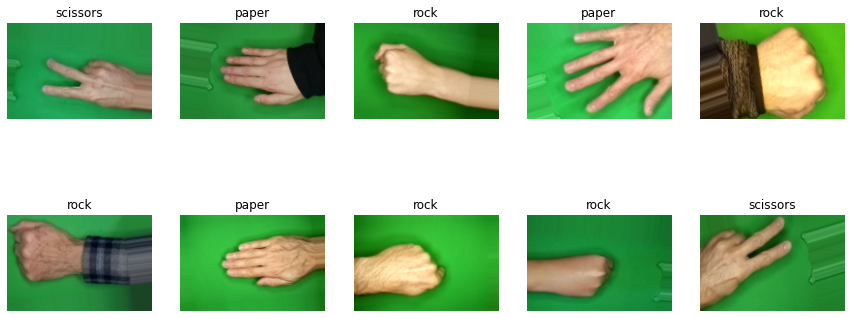

In [ ]:
target_labels = next(os.walk(base_dir))[1]
target_labels.sort()
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

## **Membuat Model**

Membangun arsitektur CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

Memanggil fungsi compile pada objek model, dan tentukan loss function serta optimizer.

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']               
)

## **Melatih Model**

### **Membuat Callback**

In [ ]:
# Callback agar train berhenti jika accuracy mencapai 97%
accuracy_threshold = 97e-2              
class accuracy_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:       # berhenti jika accuracy mencapai >= 0.97
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

### **Training**

In [ ]:
# Latih model dengan model.fit
history = model.fit(
    train_generator, 
    steps_per_epoch = 20, 
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose = 2,
    callbacks = [accuracy_callbacks()]
)

Epoch 1/30
20/20 - 23s - loss: 1.1055 - accuracy: 0.3641 - val_loss: 1.0647 - val_accuracy: 0.4250
Epoch 2/30
20/20 - 21s - loss: 1.0633 - accuracy: 0.4656 - val_loss: 1.0288 - val_accuracy: 0.5000
Epoch 3/30
20/20 - 21s - loss: 0.8917 - accuracy: 0.6443 - val_loss: 0.7331 - val_accuracy: 0.7000
Epoch 4/30
20/20 - 21s - loss: 0.5965 - accuracy: 0.7393 - val_loss: 0.5193 - val_accuracy: 0.8062
Epoch 5/30
20/20 - 21s - loss: 0.4267 - accuracy: 0.8082 - val_loss: 0.4047 - val_accuracy: 0.8250
Epoch 6/30
20/20 - 22s - loss: 0.4286 - accuracy: 0.8344 - val_loss: 0.4134 - val_accuracy: 0.8125
Epoch 7/30
20/20 - 22s - loss: 0.3467 - accuracy: 0.8641 - val_loss: 0.4189 - val_accuracy: 0.8375
Epoch 8/30
20/20 - 21s - loss: 0.4143 - accuracy: 0.8410 - val_loss: 0.3479 - val_accuracy: 0.8438
Epoch 9/30
20/20 - 21s - loss: 0.3727 - accuracy: 0.8623 - val_loss: 0.4408 - val_accuracy: 0.8313
Epoch 10/30
20/20 - 22s - loss: 0.2909 - accuracy: 0.9031 - val_loss: 0.3260 - val_accuracy: 0.8813
Epoch 11/

### **Visualisasi Akurasi**

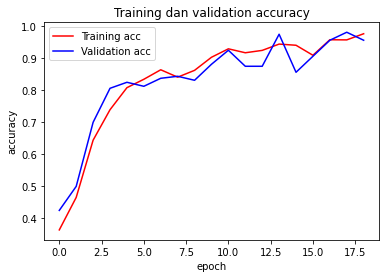

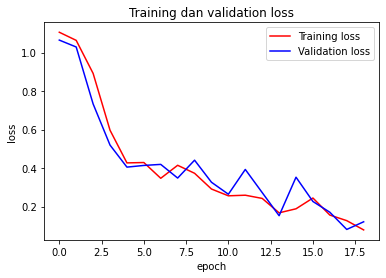

In [ ]:
# Membuat chart training dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Training dan validation accuracy
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training dan validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

# Training dan validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training dan validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()

plt.show()

## **Testing**

Secara interaktif memilih sebuah berkas gambar, kemudian melakukan resize gambar dan mengubahnya menjadi larik numpy. Prediksi dari model:

Saving IMG_20210725_152108.jpg to IMG_20210725_152108.jpg
IMG_20210725_152108.jpg
paper


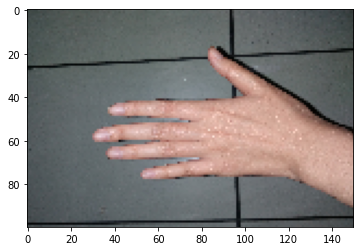

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = fn
  img_source = image.load_img(path, target_size = (100, 150))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes[0, 0] == 1:
    print('paper')
  elif classes[0, 1] == 1:
    print('rock')
  elif classes[0, 2] == 1:
    print('scissors')